<a href="https://www.kaggle.com/code/yaseredkina/pastel-forecast-eda-ml-pipeline?scriptVersionId=227252876" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import xgboost as XGBClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
# Set style for plots
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Pastel1")

In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')

In [4]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (2190, 13)
Test data shape: (730, 12)


In [5]:
# Check for missing values
print("\nMissing values in train data:")
missing_train = train_data.isnull().sum()
print(missing_train[missing_train > 0])

print("\nMissing values in test data:")
missing_test = test_data.isnull().sum()
print(missing_test[missing_test > 0])



Missing values in train data:
Series([], dtype: int64)

Missing values in test data:
winddirection    1
dtype: int64


In [6]:
# Fill missing values with mean
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

In [7]:
# Target variable distribution
target_counts = train_data['rainfall'].value_counts(normalize=True) * 100
print(f"No rain (0): {target_counts[0]:.2f}%")
print(f"Rain (1): {target_counts[1]:.2f}%")

No rain (0): 24.66%
Rain (1): 75.34%


Text(0, 0.5, 'Count')

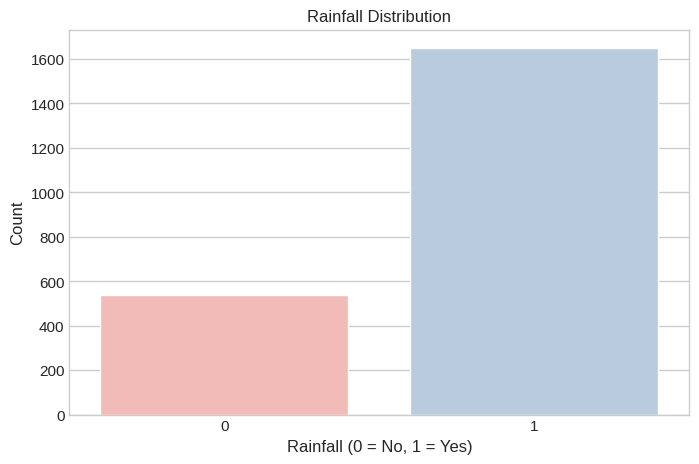

In [8]:
# Plotting target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rainfall', data=train_data)
plt.title('Rainfall Distribution')
plt.xlabel('Rainfall (0 = No, 1 = Yes)')
plt.ylabel('Count')

# **Correlation Matrix**

I plotted a heatmap to visualize the correlation matrix, which helps identify the relationships between different features in the dataset and rainfall.

**Positively Correlated (descending):**
	
* Humidity
* Cloud cover
* Windspeed
* Dewpoint


**Negatively Correlated:**
* Sunshine

# **❓ 💦  🔄  ⚡☁️💨🌞**
**My findings are supported by the plots (see below):**
	

* There is an inverse correlation between sunshine and rainy conditions (more sunshine — less rain).
* Low dewpoint correlates with no rain.
* High humidity (above medium level) is associated with a high probability of rain.
* Cloud cover is an indicator of rain.
* Higher wind speed is associated with greater probability of rain.
* Temperature, wind direction, and pressure also show some relationship with rainfall.

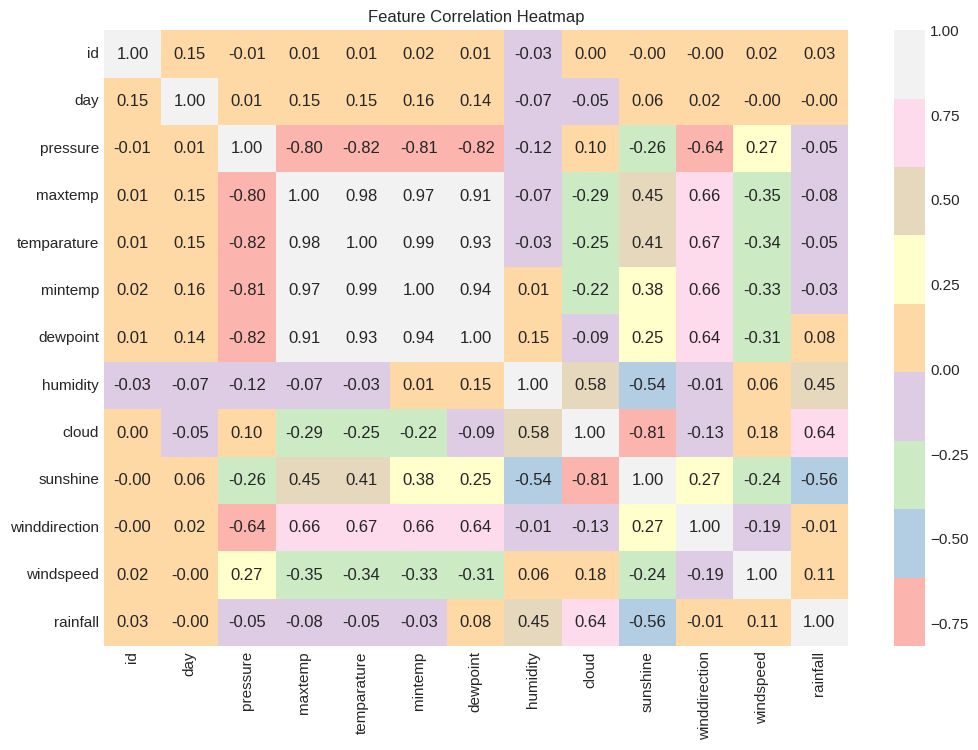

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='Pastel1', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

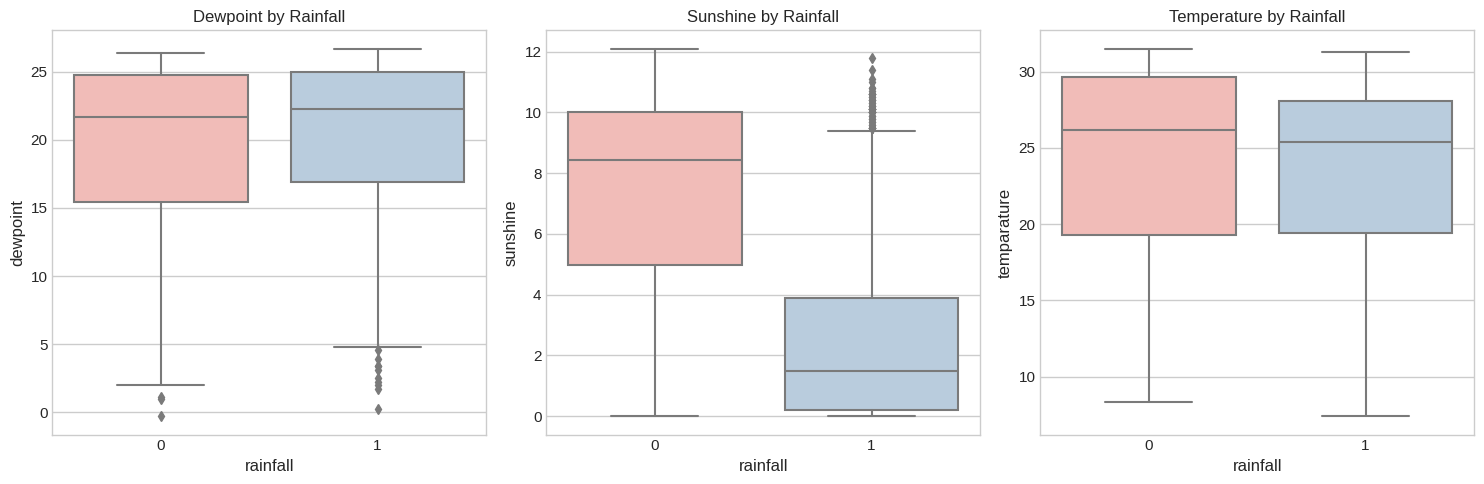

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='rainfall', y='dewpoint', data=train_data, palette='Pastel1')
plt.title('Dewpoint by Rainfall')
plt.subplot(1, 3, 2)
sns.boxplot(x='rainfall', y='sunshine', data=train_data, palette='Pastel1')
plt.title('Sunshine by Rainfall')
plt.subplot(1, 3, 3)
sns.boxplot(x='rainfall', y='temparature', data=train_data, palette='Pastel1')
plt.title('Temperature by Rainfall')
plt.tight_layout()

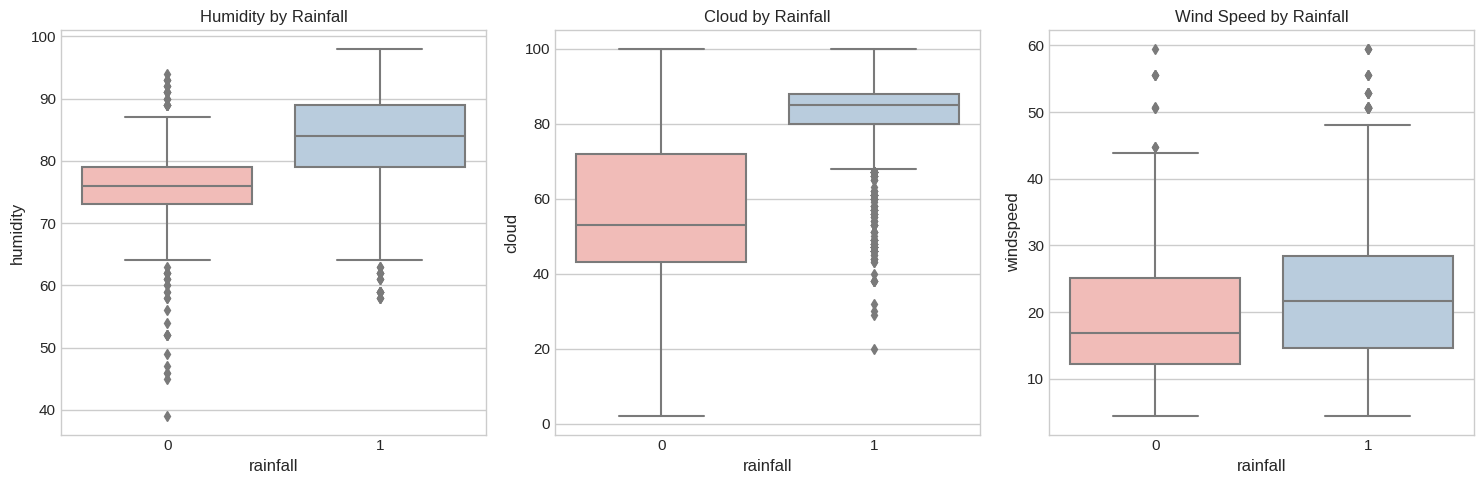

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='rainfall', y='humidity', data=train_data, palette='Pastel1')
plt.title('Humidity by Rainfall')
plt.subplot(1, 3, 2)
sns.boxplot(x='rainfall', y='cloud', data=train_data, palette='Pastel1')
plt.title('Cloud by Rainfall')
plt.subplot(1, 3, 3)
sns.boxplot(x='rainfall', y='windspeed', data=train_data, palette='Pastel1')
plt.title('Wind Speed by Rainfall')
plt.tight_layout()

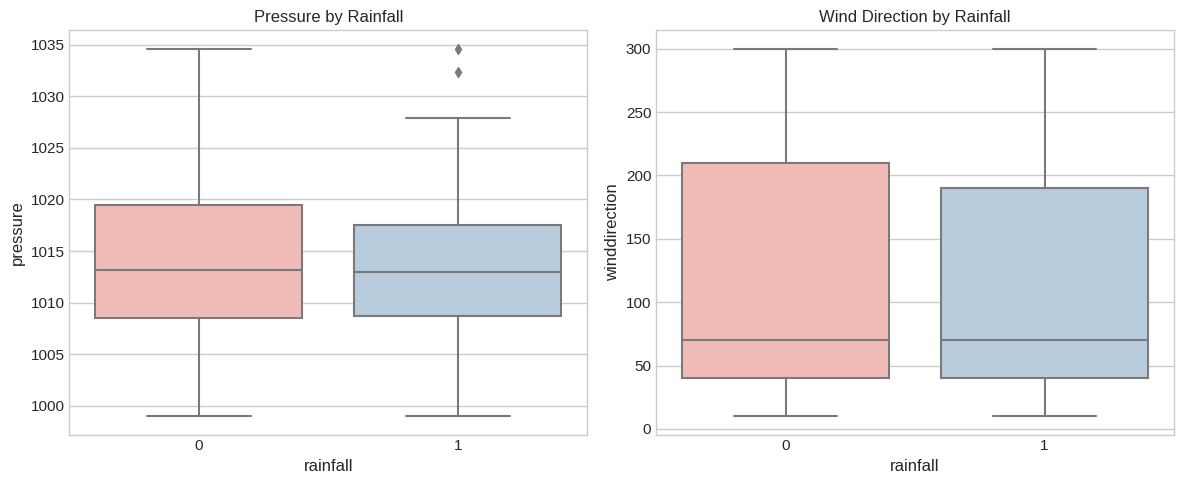

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='rainfall', y='pressure', data=train_data, palette='Pastel1')
plt.title('Pressure by Rainfall')
plt.subplot(1, 2, 2)
sns.boxplot(x='rainfall', y='winddirection', data=train_data, palette='Pastel1')
plt.title('Wind Direction by Rainfall')
plt.tight_layout()

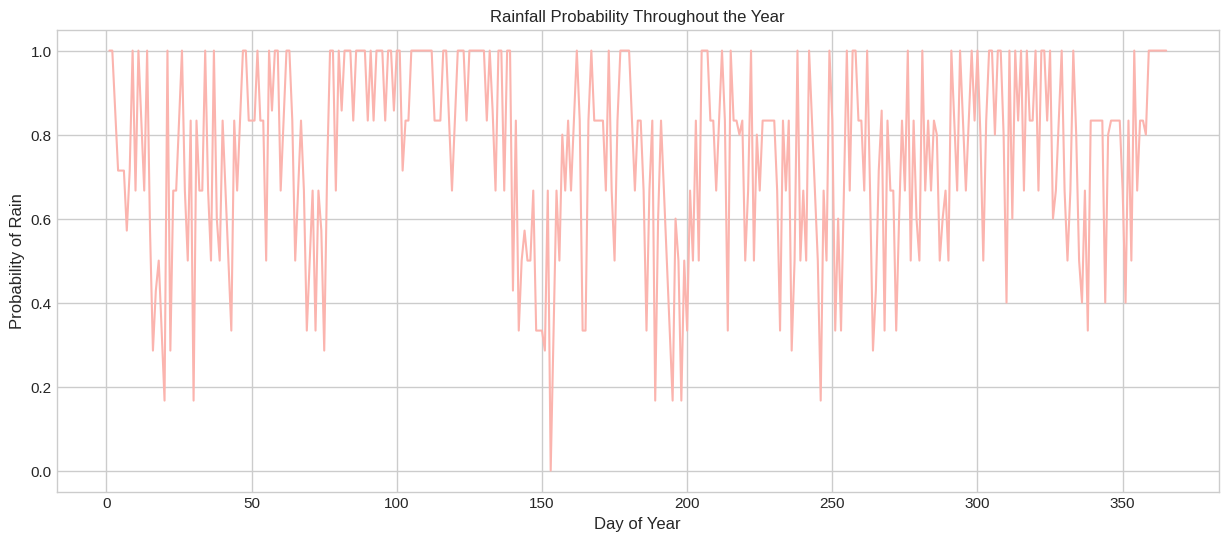

In [13]:
# Rainfall by day of year (seasonal patterns)
train_data['day_of_year'] = train_data['day']
plt.figure(figsize=(15, 6))
daily_rain = train_data.groupby('day_of_year')['rainfall'].mean()
daily_rain.plot()
plt.title('Rainfall Probability Throughout the Year')
plt.xlabel('Day of Year')
plt.ylabel('Probability of Rain')
plt.grid(True)

# 🌧️ Looks like Southern Hemisphere data! 🌧️

Looking at this rainfall probability distribution throughout the year, we can conclude this data is likely from the Southern Hemisphere. 

The rainfall patterns don't follow typical Northern Hemisphere seasonal distributions, and when combined with the explicit Southern Hemisphere season definitions in the code (Summer: Dec-Feb, Winter: Jun-Aug), it strongly suggests the data represents weather patterns from a location in the Southern Hemisphere, such as Australia, New Zealand, South Africa, or parts of South America.

In [14]:
# Calculate month from day (approximate)
train_data['month'] = ((train_data['day'] - 1) // 30) + 1
train_data['month'] = train_data['month'].clip(1, 12)  # Ensure month is between 1-12
test_data['month'] = ((test_data['day'] - 1) // 30) + 1
test_data['month'] = test_data['month'].clip(1, 12)

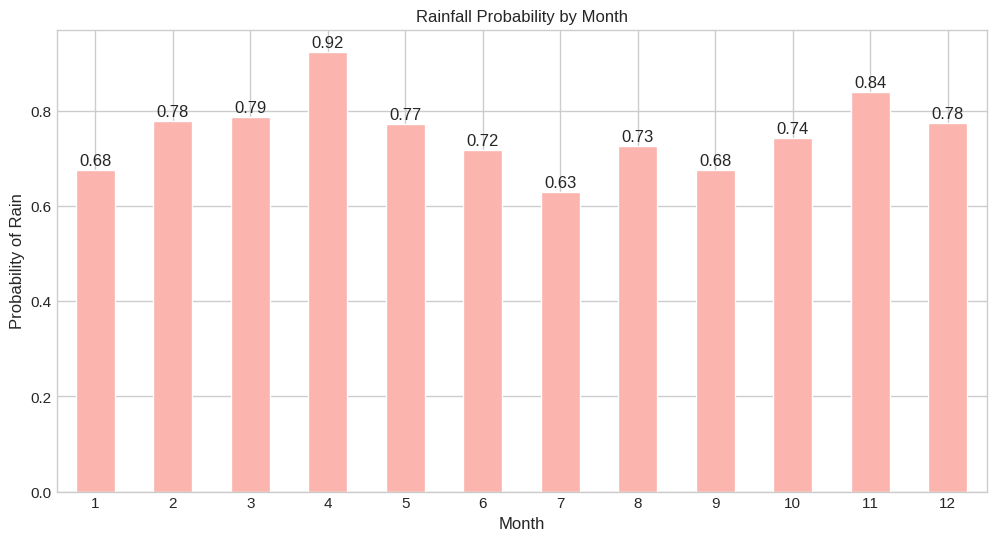

In [15]:
# Rainfall by month
plt.figure(figsize=(12, 6))
monthly_rain = train_data.groupby('month')['rainfall'].mean()
ax = monthly_rain.plot(kind='bar')
plt.title('Rainfall Probability by Month')
plt.xlabel('Month')
plt.ylabel('Probability of Rain')
plt.xticks(rotation=0)
for i, v in enumerate(monthly_rain):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center')

# FEATURE ENGINEERING

In [16]:
def prepare_features(df):
    # Copy to avoid modifying original data
    data = df.copy()
    
    # Temporal features
    data['day_of_year'] = data['day']
    data['month'] = ((data['day'] - 1) // 30) + 1
    data['month'] = data['month'].clip(1, 12)
    
    # Create season
    # 1: Summer (Dec-Feb), 2: Autumn (Mar-May), 3: Winter (Jun-Aug), 4: Spring (Sep-Nov)
    data['season'] = np.where(data['month'] <= 2, 1, 
                     np.where(data['month'] <= 5, 2, 
                     np.where(data['month'] <= 8, 3, 
                     np.where(data['month'] <= 11, 4, 1))))
    
    # Year cycle using sine and cosine transformations
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
    
    # Temperature variations
    data['temp_range'] = data['maxtemp'] - data['mintemp']
    data['temp_maxdiff'] = data['maxtemp'] - data['temparature']
    data['temp_mindiff'] = data['temparature'] - data['mintemp']
    
    # Moisture-related features
    data['dew_depression'] = data['temparature'] - data['dewpoint']
    data['relative_humidity'] = data['humidity'] / 100
    
    # Wind features
    data['wind_dir_rad'] = np.radians(data['winddirection'])
    data['wind_dir_sin'] = np.sin(data['wind_dir_rad'])
    data['wind_dir_cos'] = np.cos(data['wind_dir_rad'])
    
    # Interaction features based on your observations
    data['humidity_cloud'] = data['humidity'] * data['cloud'] / 100  # Clouds and humidity together indicate rain
    data['sunshine_inverse'] = 1 / (data['sunshine'] + 0.1)  # Low sunshine = higher rain chance
    data['dewpoint_humid_ratio'] = data['dewpoint'] / (data['humidity'] + 0.1)  # Relationship between humidity and dewpoint
    
    # Additional interaction features
    data['wind_pressure'] = data['windspeed'] * data['pressure'] / 1000
    data['temp_humidity'] = data['temparature'] * data['relative_humidity']
    data['cloud_sunshine_ratio'] = data['cloud'] / (data['sunshine'] + 0.1)
    
    # Instability index
    data['instability_index'] = (data['temp_range'] * data['relative_humidity']) / (data['pressure'] / 1000)
    
    # Сombining wind speed and direction
    data['wind_factor'] = data['windspeed'] * data['wind_dir_sin']
    
    # Drop unnecessary columns
    data.drop(['wind_dir_rad'], axis=1, inplace=True)
    
    return data

In [17]:
# Prepare data
train_processed = prepare_features(train_data)
test_processed = prepare_features(test_data)

# Define features -- using a blend of your features and additional ones
selected_features = [
    'humidity', 'cloud', 'sunshine', 'windspeed', 'dewpoint', 'winddirection', 'pressure', 'temparature',
    'maxtemp', 'mintemp', 
    # Engineered features
    'temp_range', 'dew_depression', 'day_sin', 'day_cos', 
    'humidity_cloud', 'sunshine_inverse', 'wind_dir_sin', 'wind_dir_cos',
    'instability_index', 'temp_humidity', 'cloud_sunshine_ratio'
]

# Ensure all selected features exist in the dataframe
existing_features = [f for f in selected_features if f in train_processed.columns]

# Define features and target
X = train_processed[existing_features]
y = train_processed['rainfall']

In [18]:
# Feature importance with Random Forest
rf_initial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_initial.fit(X, y)
feature_importance = pd.DataFrame({
    'Feature': existing_features,
    'Importance': rf_initial.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string (index=False))


Top 10 most important features:
             Feature  Importance
      humidity_cloud    0.140775
               cloud    0.128374
cloud_sunshine_ratio    0.116768
            sunshine    0.085991
    sunshine_inverse    0.069414
            humidity    0.041764
      dew_depression    0.035968
       temp_humidity    0.033984
           windspeed    0.033728
             day_sin    0.032206


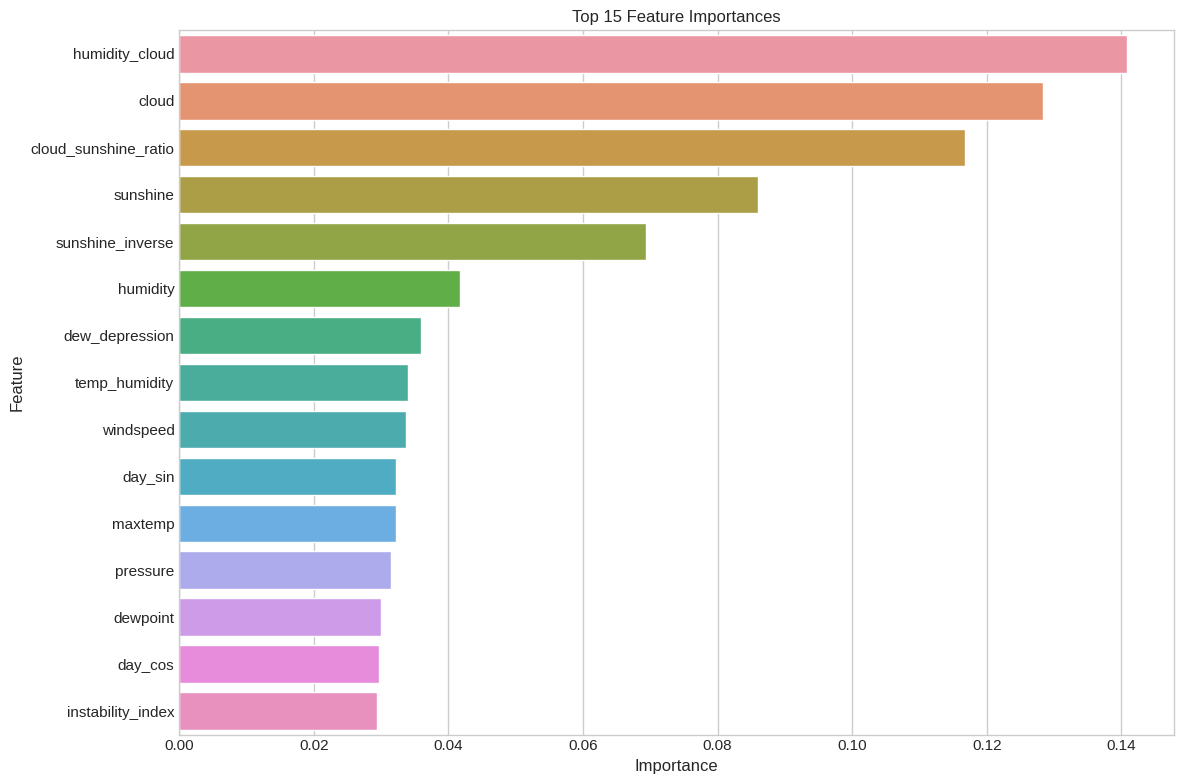

In [19]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()

# Southern Hemisphere Rainfall Patterns: What the Data Reveals

- **April showers bring flowers!** Highest rainfall probability (0.92) occurs in autumn
- **July's dry spell?** Lowest rainfall (0.63) hits during winter months
- **Cloud cover = rain inevitable** (strongest correlation at 0.64)
- **Sunshine disappears when rain appears** (negative correlation of -0.56)
- **Humidity rises, rain materializes** – they're partners in atmospheric crime
- **When clouds gather, grab your umbrella** – most reliable predictor of incoming rain
- **Pressure barely budges** whether rain falls or not – it's keeping its secrets!
- **Temperature plays it cool** with minimal change during rainfall

Southern hemisphere signature? Absolutely! The seasonal pattern flips the northern hemisphere script – peak rain in April/November (autumn/spring) matches perfectly with regions like Australia, South Africa, or South America.

# MODEL BUILDING AND EVALUATION

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training Logistic Regression...
Logistic Regression - Test ROC AUC: 0.8805
Logistic Regression - CV ROC AUC: 0.8932 ± 0.0225

Training Random Forest...
Random Forest - Test ROC AUC: 0.8714
Random Forest - CV ROC AUC: 0.8778 ± 0.0248

Training XGBoost...
XGBoost - Test ROC AUC: 0.8512
XGBoost - CV ROC AUC: 0.8594 ± 0.0251

Training SVM...
SVM - Test ROC AUC: 0.8113
SVM - CV ROC AUC: 0.8832 ± 0.0264

Training Gradient Boosting...
Gradient Boosting - Test ROC AUC: 0.8608
Gradient Boosting - CV ROC AUC: 0.8802 ± 0.0292

Training LightGBM...
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Sta

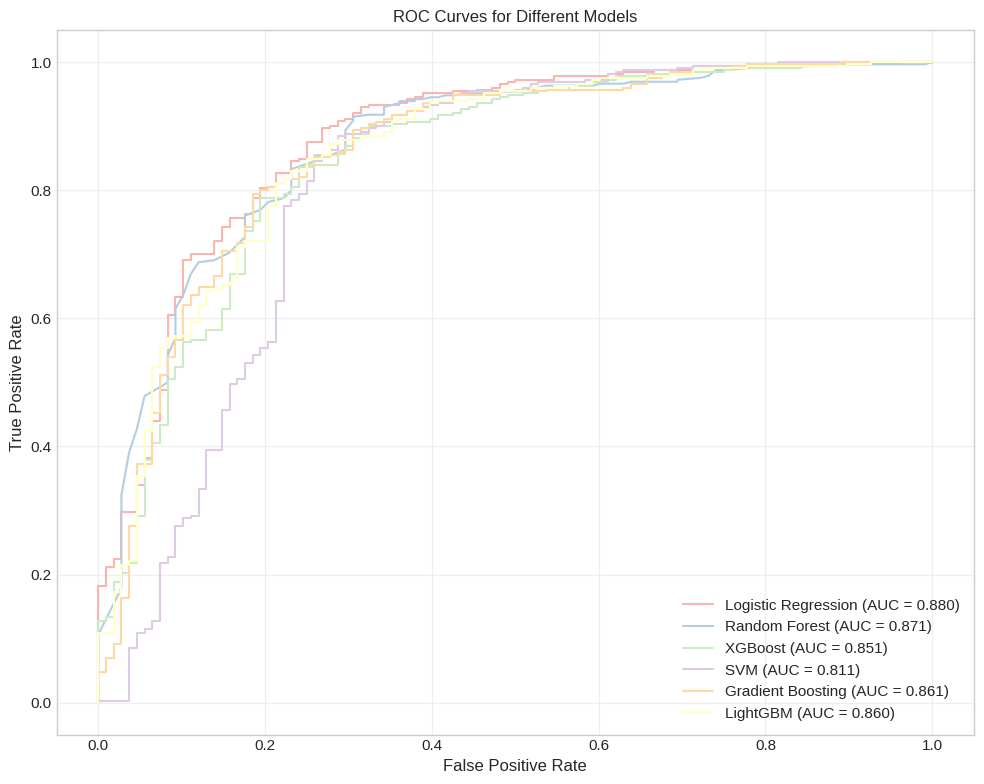

In [21]:
# Models
models = {
    "Logistic Regression": LogisticRegression(C=1, solver='liblinear'),  # Using your best params
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(C=10, kernel='rbf', probability=True, random_state=42),  # Using your best params
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models with ROC curves
plt.figure(figsize=(10, 8))
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_scores)
    results[name] = roc_auc
    
    # Calculate FPR, TPR for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    print(f"{name} - Test ROC AUC: {roc_auc:.4f}")
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Add labels, title and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Find best model

In [22]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name} with ROC AUC: {results[best_model_name]:.4f}")


Best performing model: Logistic Regression with ROC AUC: 0.8805


# HYPERPARAMETER TUNING

In [23]:
# Define parameter grid based on the best model
if best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'penalty': ['l2', 'l1']
    }
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif best_model_name == "SVM":
    param_grid = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == "LightGBM":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, -1],
        'num_leaves': [31, 63, 127]
    }

In [24]:
# Use a smaller grid for quicker execution
small_param_grid = {k: param_grid[k][:2] for k in list(param_grid.keys())[:3]}

print(f"Tuning hyperparameters for {best_model_name}...")
grid_search = GridSearchCV(
    best_model,
    param_grid=small_param_grid,
    cv=3,  # Reduced for speed
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")

Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.8959


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver 

# CREATING ENSEMBLE MODEL

In [25]:
best_model = grid_search.best_estimator_

# Select top 3 models for ensemble
sorted_models = sorted(results.items(), key=lambda x: x[1], reverse=True)
top_models_names = [name for name, _ in sorted_models[:3]]
top_models = [models[name] for name in top_models_names]

print(f"Creating ensemble of top 3 models: {', '.join(top_models_names)}")

# Train top models on full training data
for name, model in zip(top_models_names, top_models):
    model.fit(X_train_scaled, y_train)

Creating ensemble of top 3 models: Logistic Regression, Random Forest, Gradient Boosting


In [26]:
# Create ensemble predictions
def ensemble_predict(models, X):
    predictions = np.zeros(len(X))
    for model in models:
        predictions += model.predict_proba(X)[:, 1]
    return predictions / len(models)

# Evaluate ensemble on test set
ensemble_preds = ensemble_predict(top_models, X_test_scaled)
ensemble_auc = roc_auc_score(y_test, ensemble_preds)
print(f"Ensemble model ROC AUC: {ensemble_auc:.4f}")

Ensemble model ROC AUC: 0.8770


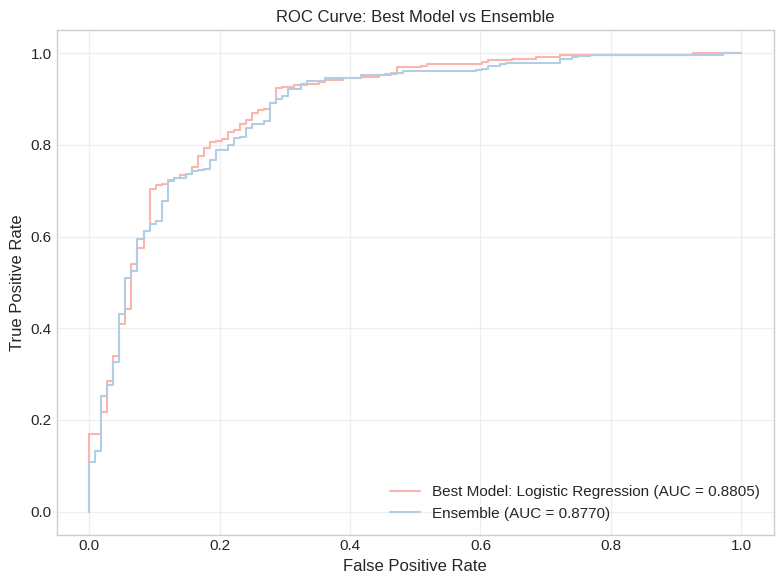

In [27]:
# Plot ROC Curve for Best Single Model
plt.figure(figsize=(8, 6))

# Best single model
y_scores_best = best_model.predict_proba(X_test_scaled)[:, 1]
fpr_best, tpr_best, thresholds = roc_curve(y_test, y_scores_best)
plt.plot(fpr_best, tpr_best, label=f'Best Model: {best_model_name} (AUC = {results[best_model_name]:.4f})')

# Ensemble model
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_preds)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {ensemble_auc:.4f})')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Best Model vs Ensemble')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Better Performance of the Single Model:** Since the single model’s ROC curve is higher and to the left of the ensemble’s, it indicates that the single model is achieving a better balance between sensitivity and specificity.

# FINAL PREDICTION AND SUBMISSION

In [28]:
# Choose final model
if ensemble_auc > results[best_model_name]:
    print("Using ensemble model for final predictions")
    # Scale test data
    X_test_final = test_processed[existing_features]
    X_test_final_scaled = scaler.transform(X_test_final)
    
    # Generate predictions with ensemble
    final_predictions = ensemble_predict(top_models, X_test_final_scaled)
else:
    print(f"Using {best_model_name} for final predictions")
    # Fit best model on all training data
    best_model.fit(scaler.transform(X), y)
    
    # Generate predictions with best model
    X_test_final = test_processed[existing_features]
    X_test_final_scaled = scaler.transform(X_test_final)
    final_predictions = best_model.predict_proba(X_test_final_scaled)[:, 1]

Using Logistic Regression for final predictions


In [29]:
# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'rainfall': final_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: 'submission.csv'")


Submission file created: 'submission.csv'


# Summary

In [30]:
print(f"Best single model: {best_model_name}, ROC AUC: {results[best_model_name]:.4f}")
print(f"Ensemble model ROC AUC: {ensemble_auc:.4f}")
print(f"Final model used: {'Ensemble' if ensemble_auc > results[best_model_name] else best_model_name}")
print(f"Total features used: {len(existing_features)}")
print(f"Top 5 most important features: {', '.join(feature_importance['Feature'].head(5))}")
print(f"Test set predictions generated: {len(submission)}")

Best single model: Logistic Regression, ROC AUC: 0.8805
Ensemble model ROC AUC: 0.8770
Final model used: Logistic Regression
Total features used: 21
Top 5 most important features: humidity_cloud, cloud, cloud_sunshine_ratio, sunshine, sunshine_inverse
Test set predictions generated: 730
